In [6]:
%matplotlib inline

import os
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import harmonypy
from cnmf import cNMF
import seaborn as sns
import yaml
from scipy.stats import pearsonr
from IPython.display import Image
from matplotlib.pyplot import rc_context

sys.path.append('../../../Code/')
from utils import read_dataset_log, match_columns

# Myeloid

In [7]:
paths ={'Original': '../../../Data/PerDataset/HaoEtAl/haoetal_pbmc_multimodal.merged.ADTfixed.h5ad',
 'RNA_Varnorm_Harmony': '../../../Data/PerDataset/HaoEtAl/haoetal_pbmc_multimodal.merged.ADTfixed.Myeloid.20231227.RNA.VarNorm.HVG.HarmonyGeneCorrect.h5ad',
 'RNA_HVG_List': '../../../Data/PerDataset/HaoEtAl/haoetal_pbmc_multimodal.merged.ADTfixed.Myeloid.20231227.RNA.HVGlist.tsv',
 'Metadata': '../../../Data/PerDataset/HaoEtAl/haoetal_pbmc_multimodal.merged.ADTfixed.Myeloid.20231227.metadata.tsv',
 'Raw_Filt_For_cNMF': '../../../Data/PerDataset/HaoEtAl/haoetal_pbmc_multimodal.merged.ADTfixed.Myeloid.20231227.FiltForcNMF.h5ad',
 'ADT_MI_Rank': '../../../Data/PerDataset/HaoEtAl/haoetal_pbmc_multimodal.merged.ADTfixed.Myeloid.20231227.ADT.TP10K.VarNorm.leidenRNA_MI.tsv',
 'ADT_Varnom_Harmony': '../../../Data/PerDataset/HaoEtAl/haoetal_pbmc_multimodal.merged.ADTfixed.Myeloid.20231227.ADT.VarNorm.HVG.HarmonyGeneCorrect.h5ad',
 'RNA_and_ADT_TP10K': '../../../Data/PerDataset/HaoEtAl/haoetal_pbmc_multimodal.merged.ADTfixed.Myeloid.20231227.RNA_and_ADT.TP10K.h5ad',
 'RNA_and_ADT_HVG_List': '../../../Data/PerDataset/HaoEtAl/haoetal_pbmc_multimodal.merged.ADTfixed.Myeloid.20231227.RNA_and_ADT.HVGlist.tsv',
 'RNA_and_ADT_Varnorm_Harmony_WNN': '../../../Data/PerDataset/HaoEtAl/haoetal_pbmc_multimodal.merged.ADTfixed.Myeloid.20231227.RNA_and_ADT.VarNorm.HVG.HarmonyGeneCorrect.h5mu',
 'RNA_and_ADT_Varnorm_Harmony': '../../../Data/PerDataset/HaoEtAl/haoetal_pbmc_multimodal.merged.ADTfixed.Myeloid.20231227.RNA_and_ADT.VarNorm.HVG.HarmonyGeneCorrect.h5ad',
 'WNN_UMAP': '../../../Data/PerDataset/HaoEtAl/haoetal_pbmc_multimodal.merged.ADTfixed.Myeloid.20231227.RNA_and_ADT.TP10K.VarNorm.HVG.HarmonyGeneCorrect.WNN.UMAP.tsv'}

## Run cNMF

In [3]:
cnmfdir = '../../../Data/PerDataset/HaoEtAl'
name = 'HIVVaccine.Myeloid'

In [4]:
cnmf_count_fn = paths['RNA_Varnorm_Harmony']
cnmf_tpm_fn = paths['RNA_and_ADT_TP10K']
hvg_fn = paths['RNA_HVG_List']

jname = name
cnmfout = os.path.join(cnmfdir, name, 'log')

Ks = np.arange(10, 50)
n_iter = 20
num_per_node = 10

In [5]:
cnmf_obj = cNMF(output_dir=cnmfdir, name=name)

In [6]:
cnmf_obj.prepare(counts_fn=cnmf_count_fn, components=Ks,
                 n_iter=n_iter, tpm_fn=cnmf_tpm_fn, genes_file=hvg_fn, init='random')

Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].


/PHShome/dk718/miniforge3/envs/cnmf_env2v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.h5ad'].


In [7]:
total_workers = int((len(Ks)*n_iter) / num_per_node)
total_workers

80

In [8]:
if not os.path.exists(cnmfout): os.mkdir(cnmfout)

basecmd = "export OMP_NUM_THREADS=6; cnmf factorize --name {name} --output-dir {outdir} --total-workers {tw} --worker-index {i}"
q = 'short'
other = '-R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "select[hname!=cn004]" -R "select[hname!=cn005]" -R "select[hname!=cn007]"'

for i in range(total_workers):
    cmd = basecmd.format(name=name, outdir=cnmfdir, i=i, tw=total_workers)
    e = os.path.join(cnmfout, '{j}.{i}.err.txt').format(i=i, j=jname)
    o = os.path.join(cnmfout, '{j}.{i}.out.txt').format(i=i, j=jname)
    bsub_cmd = 'bsub -q {q} -J {j} -o {o} -e {e} {other} "{cmd}"'.format(q=q, j=jname, e=e, o=o, other=other, cmd=cmd)
    print(bsub_cmd)
    !{bsub_cmd}

bsub -q short -J HIVVaccine.Myeloid -o ../../../Data/PerDataset/HaoEtAl/HIVVaccine.Myeloid/log/HIVVaccine.Myeloid.0.out.txt -e ../../../Data/PerDataset/HaoEtAl/HIVVaccine.Myeloid/log/HIVVaccine.Myeloid.0.err.txt -R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "select[hname!=cn004]" -R "select[hname!=cn005]" -R "select[hname!=cn007]" "export OMP_NUM_THREADS=6; cnmf factorize --name HIVVaccine.Myeloid --output-dir ../../../Data/PerDataset/HaoEtAl --total-workers 80 --worker-index 0"
ERROR! Session/line number was not unique in database. History logging moved to new session 1703
Job <109868> is submitted to queue <short>.
bsub -q short -J HIVVaccine.Myeloid -o ../../../Data/PerDataset/HaoEtAl/HIVVaccine.Myeloid/log/HIVVaccine.Myeloid.1.out.txt -e ../../../Data/PerDataset/HaoEtAl/HIVVaccine.Myeloid/log/HIVVaccine.Myeloid.1.err.txt -R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "se

In [9]:
! bjobs | wc -l

No unfinished job found
0


In [17]:
total_workers = int((len(Ks)*n_iter))
total_workers

800

In [18]:
import os
def worker_filter(iterable, worker_index, total_workers):
    return (p for i,p in enumerate(iterable) if (i-worker_index)%total_workers==0)

def load_df_from_npz(filename):
    with np.load(filename, allow_pickle=True) as f:
        obj = pd.DataFrame(**f)
    return obj

missing = []
run_params = load_df_from_npz(cnmf_obj.paths['nmf_replicate_parameters'])
for worker_i in range(total_workers):
    jobs_for_this_worker = worker_filter(range(len(run_params)), worker_i, total_workers)
    for idx in jobs_for_this_worker:
        p = run_params.iloc[idx, :]
        outfn = cnmf_obj.paths['iter_spectra'] % (p['n_components'], p['iter'])
        if not os.path.exists(outfn):
            print(worker_i, outfn)
            missing.append(worker_i)

In [19]:
len(missing)

0

In [20]:
basecmd = "export OMP_NUM_THREADS=6; cnmf factorize --name {name} --output-dir {outdir} --total-workers {tw} --worker-index {i}"
q = 'short'
other = '-R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "select[hname!=cn004]" -R "select[hname!=cn005]" -R "select[hname!=cn007]"'

for i in missing:
    cmd = basecmd.format(name=name, outdir=cnmfdir, i=i, tw=total_workers)
    e = os.path.join(cnmfout, '{j}.{i}.err.txt').format(i=i, j=jname)
    o = os.path.join(cnmfout, '{j}.{i}.out.txt').format(i=i, j=jname)
    bsub_cmd = 'bsub -q {q} -J {j} -o {o} -e {e} {other} "{cmd}"'.format(q=q, j=jname, e=e, o=o, other=other, cmd=cmd)
    print(bsub_cmd)
    !{bsub_cmd}

In [21]:
! bjobs

No unfinished job found


In [22]:
cnmf_obj.combine(skip_missing_files=True)

Combining factorizations for k=10.
Combining factorizations for k=11.
Combining factorizations for k=12.
Combining factorizations for k=13.
Combining factorizations for k=14.
Combining factorizations for k=15.
Combining factorizations for k=16.
Combining factorizations for k=17.
Combining factorizations for k=18.
Combining factorizations for k=19.
Combining factorizations for k=20.
Combining factorizations for k=21.
Combining factorizations for k=22.
Combining factorizations for k=23.
Combining factorizations for k=24.
Combining factorizations for k=25.
Combining factorizations for k=26.
Combining factorizations for k=27.
Combining factorizations for k=28.
Combining factorizations for k=29.
Combining factorizations for k=30.
Combining factorizations for k=31.
Combining factorizations for k=32.
Combining factorizations for k=33.
Combining factorizations for k=34.
Combining factorizations for k=35.
Combining factorizations for k=36.
Combining factorizations for k=37.
Combining factorizat

Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.h5ad'].
CPU times: user 24min 47s, sys: 45min 39s, total: 1h 10min 27s
Wall time: 7min 30s


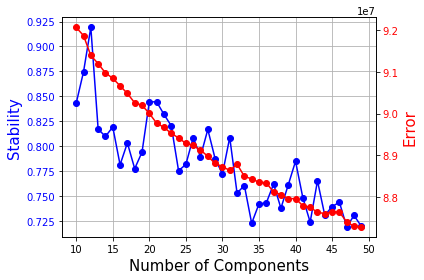

In [23]:
%%time
cnmf_obj.k_selection_plot()

In [24]:
kthresh = {21:0.15, 22:0.15, 23:0.15, 28:0.15, 31:0.15, 40:0.15, 43:0.15}


Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].


/PHShome/dk718/miniforge3/envs/cnmf_env2v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].


/PHShome/dk718/miniforge3/envs/cnmf_env2v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].


/PHShome/dk718/miniforge3/envs/cnmf_env2v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].


/PHShome/dk718/miniforge3/envs/cnmf_env2v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].


/PHShome/dk718/miniforge3/envs/cnmf_env2v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].


/PHShome/dk718/miniforge3/envs/cnmf_env2v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].


/PHShome/dk718/miniforge3/envs/cnmf_env2v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


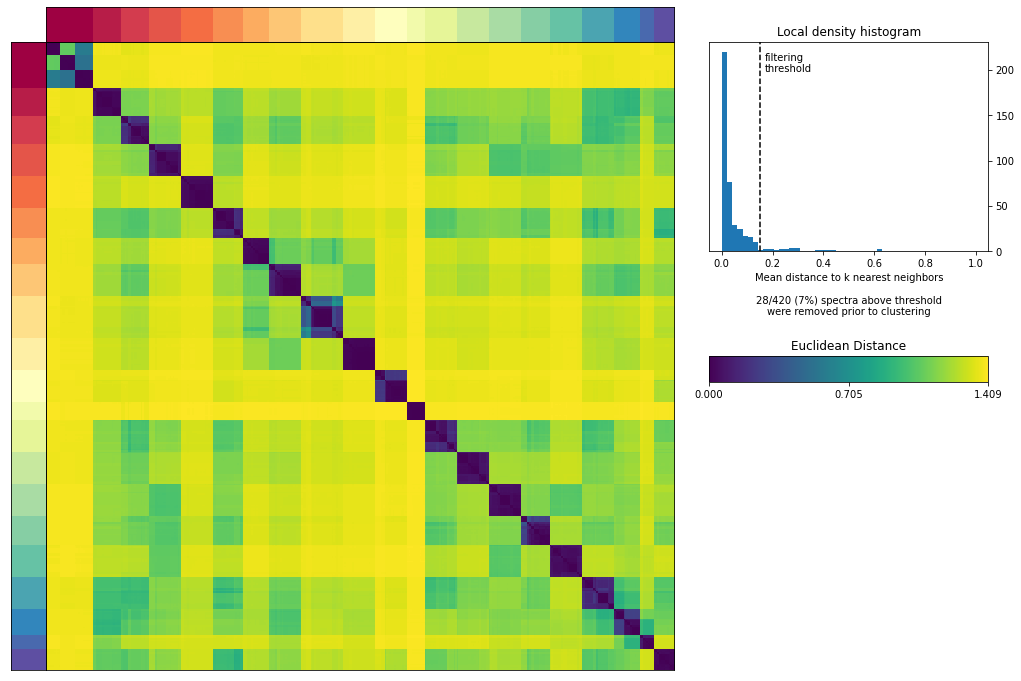

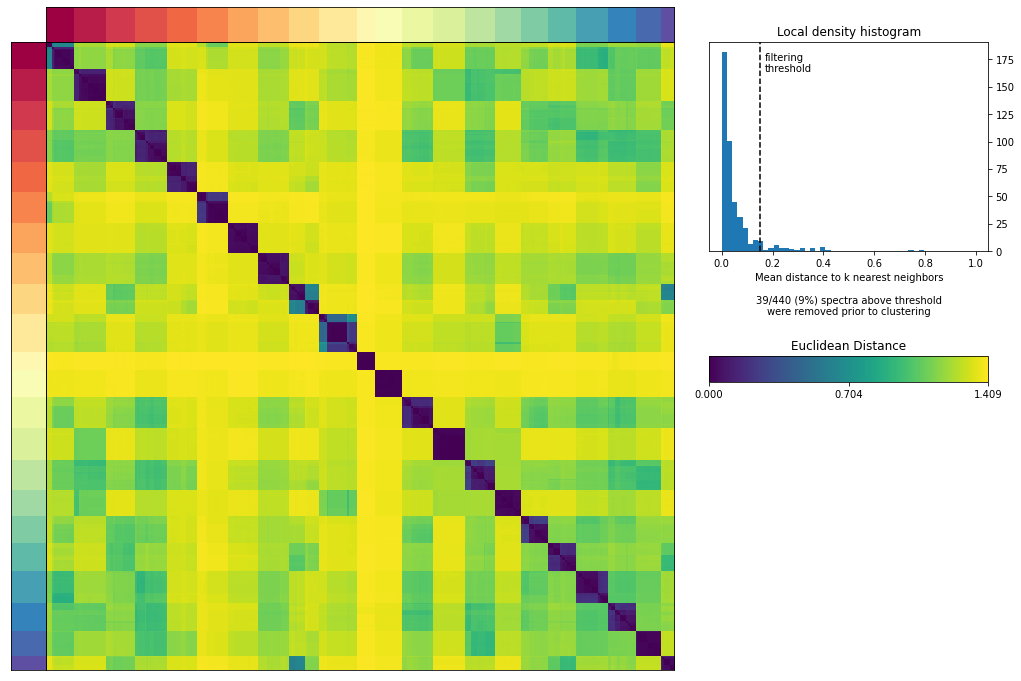

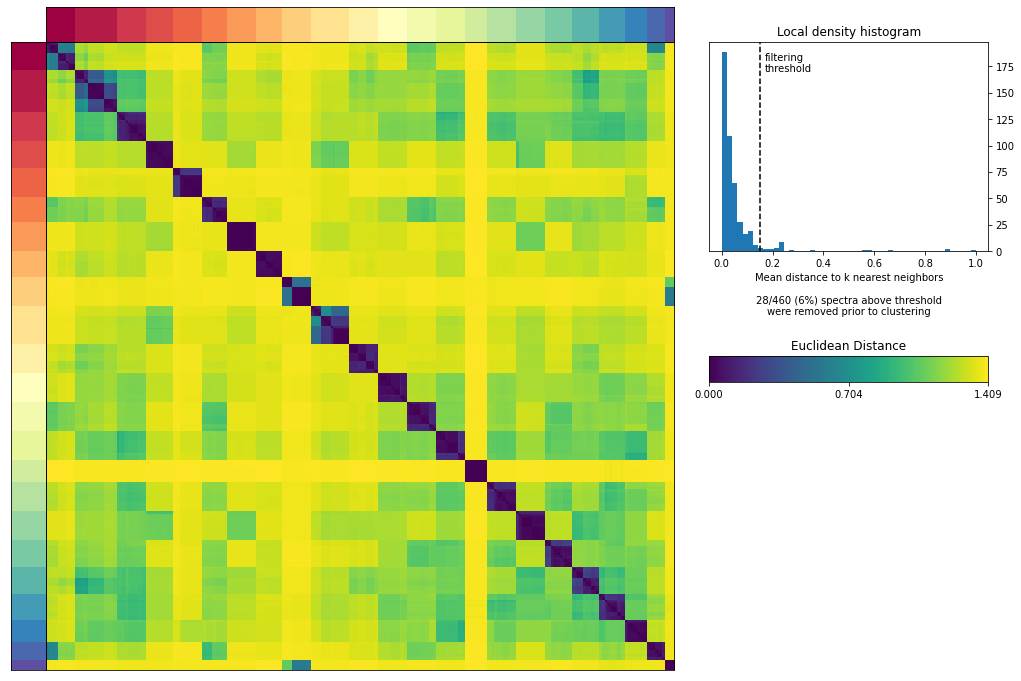

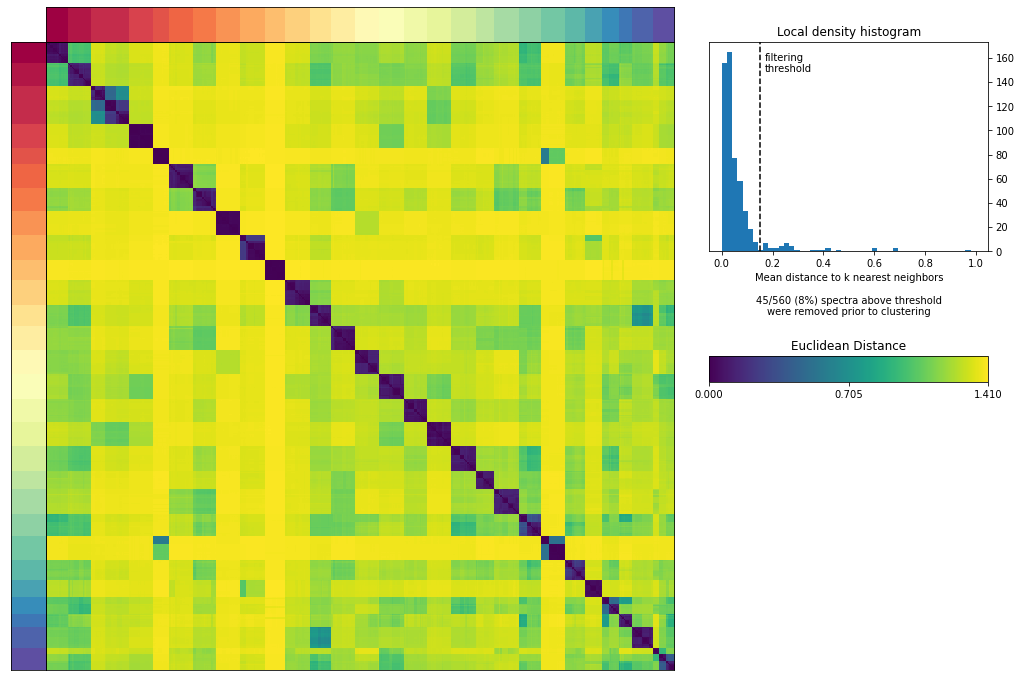

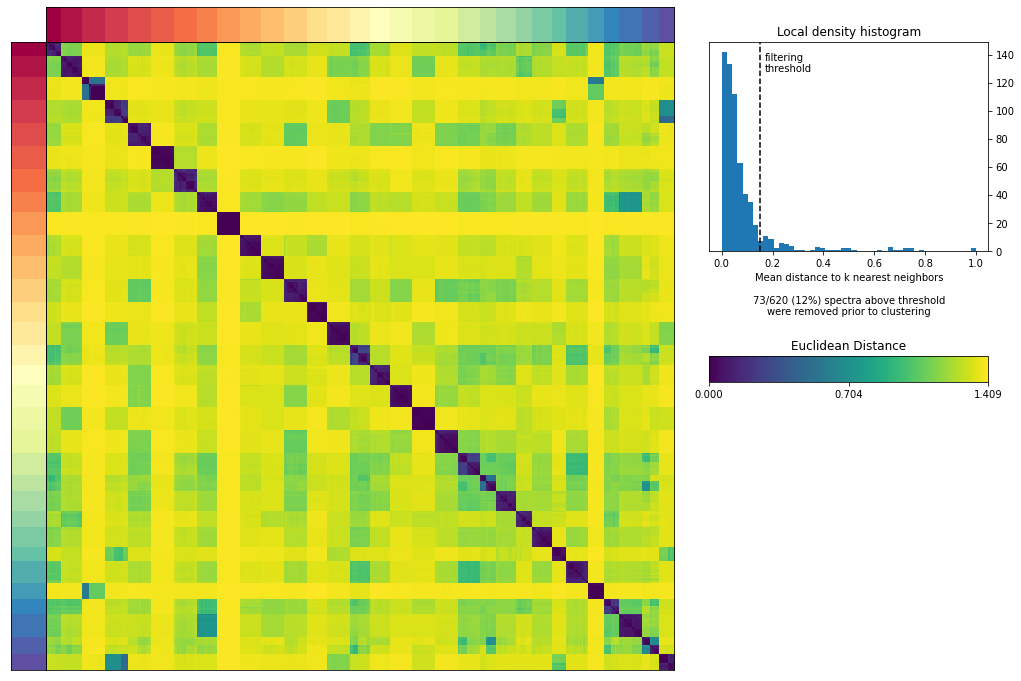

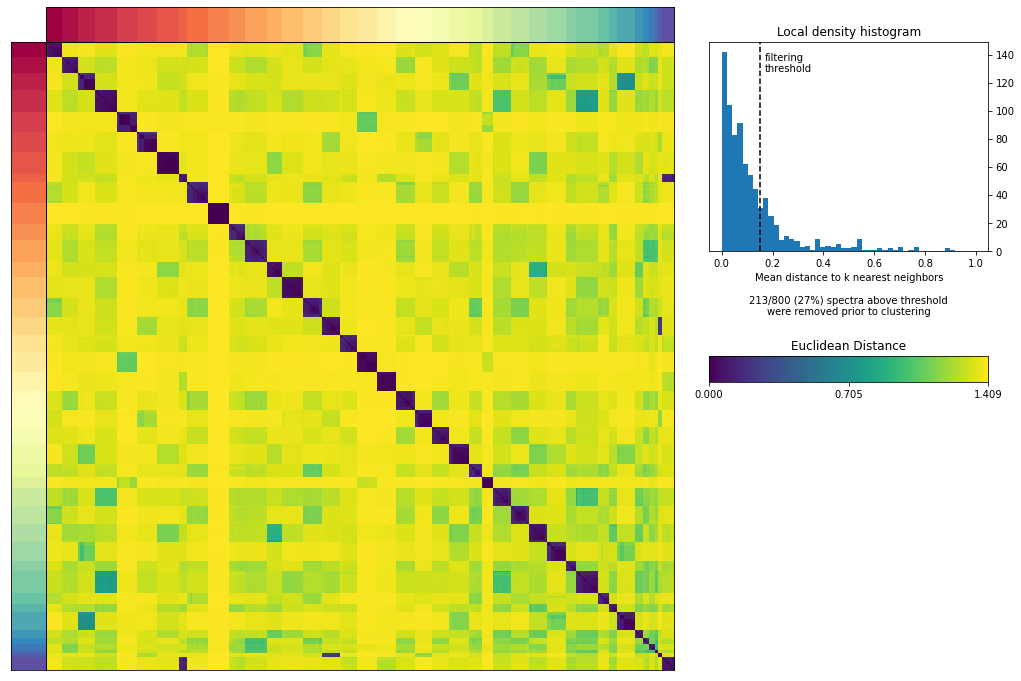

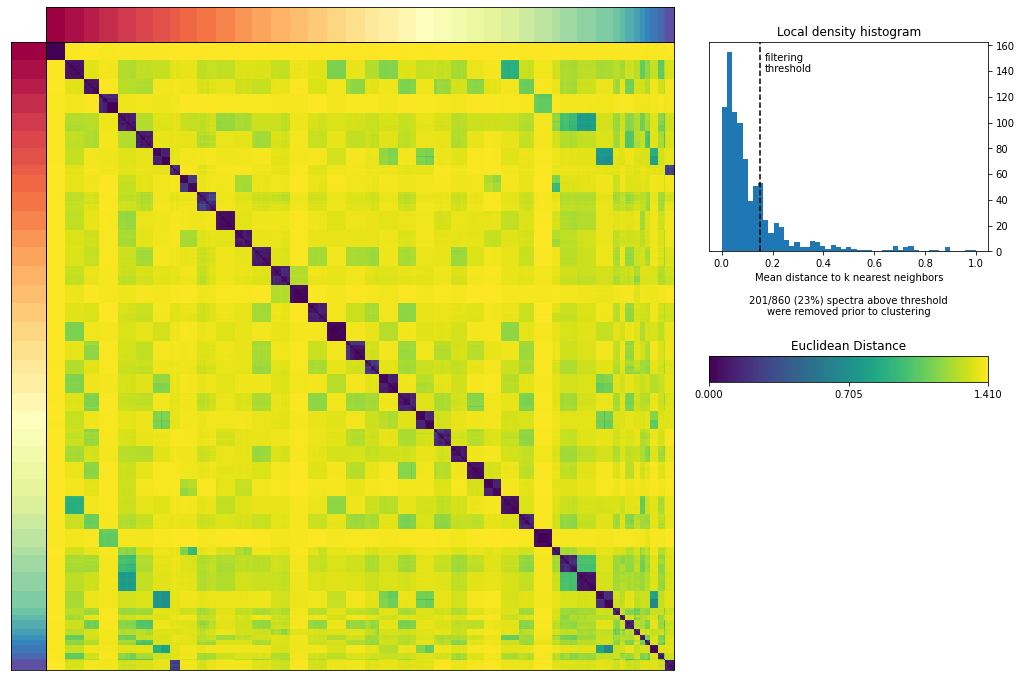

In [25]:
for k in [21, 22, 23, 28, 31, 40, 43]:
    cnmf_obj.consensus(k=k, density_threshold=kthresh[k])

Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].


/PHShome/dk718/miniforge3/envs/cnmf_env2v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].


/PHShome/dk718/miniforge3/envs/cnmf_env2v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].


/PHShome/dk718/miniforge3/envs/cnmf_env2v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


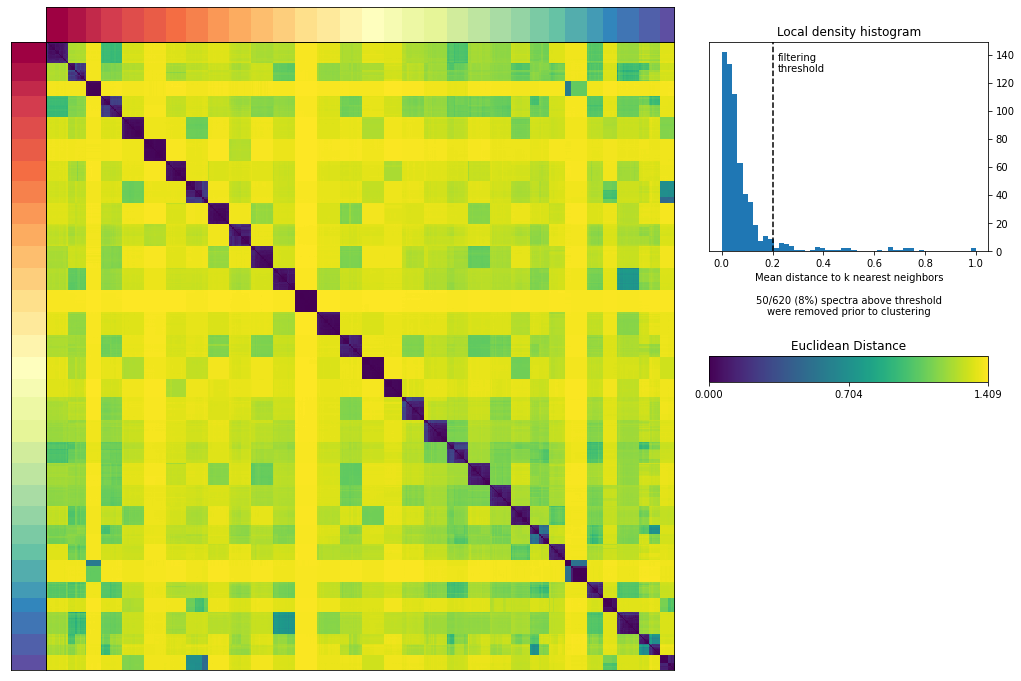

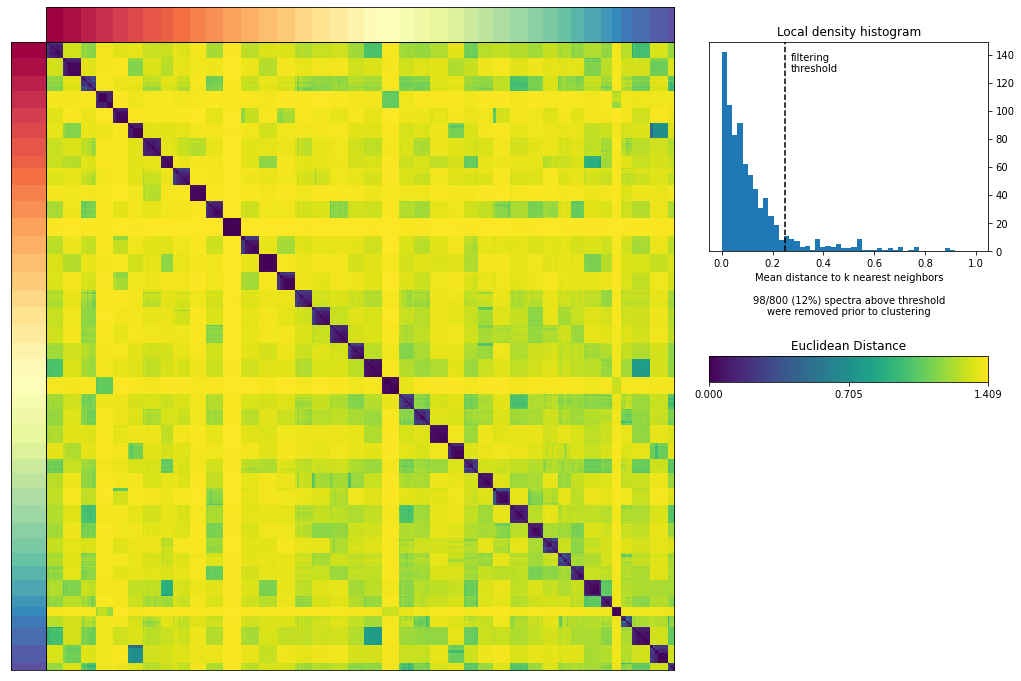

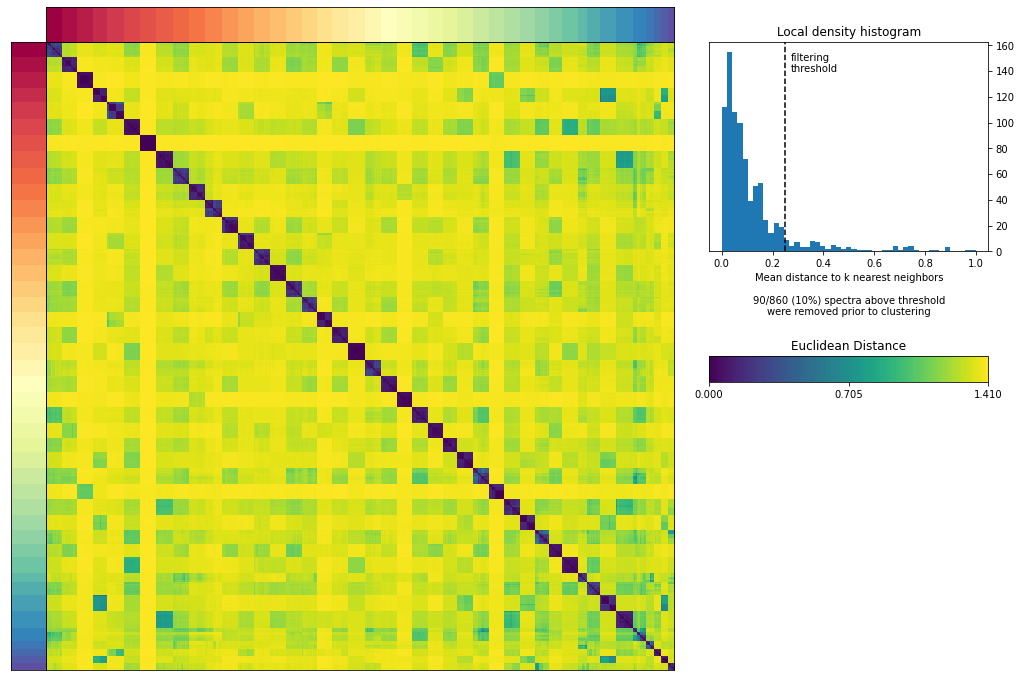

In [34]:
kthresh = {21:0.15, 22:0.15, 23:0.15, 28:0.15, 31:0.2, 40:0.25, 43:0.25}
for k in [31, 40, 43]:
    cnmf_obj.consensus(k=k, density_threshold=kthresh[k])

In [35]:
k=40
(usage, spectra_scores, spectra_tpm, top_genes) = cnmf_obj.load_results(K=k, density_threshold=kthresh[k])

In [36]:
top_genes.head(20).iloc[:,:15]

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,MNDA,PLBD1,RNASE2,NAMPT,SYNRG,RPS19,SASH1,NFKBIA,MALAT1,RPS24,EMP3,MT-ND3,S100A10,HBEGF,THBS1
1,P2RY13,S100A8,F13A1,C5AR1,RFC1,MS4A4A,LIPA,ZFP36,NEAT1,RPLP0,EZR,MT-CYB,CRIP1,NR4A2,NINJ1
2,CTSS,S100A12,AB_CD163,RGS2,UBTF,IFITM2,HLA-DMB,TNFAIP3,ZEB2,RPL10,APOBEC3A,MT-CO2,TAGLN2,GABARAPL1,C15orf48
3,ALDH1A1,S100A9,VCAN,DUSP1,SATB1,FCGR3A,HLA-DMA,PPP1R15A,MACF1,RPS27A,IKZF1,MT-ND4,VIM,VEGFA,REL
4,TKT,PADI4,AB_CD64,S100A6,DNMT1,CFD,PID1,NFKBIZ,MT-ND6,RPS3A,FBP1,MT-ND2,LMNA,OSM,NRIP1
5,CYP27A1,RBP7,CAVIN3,GLUL,CEBPZ,LST1,AB_CD305,PDE4B,UTRN,HSP90AB1,ADGRE5,MT-ATP6,ANXA1,NR4A1,PTGES
6,GIMAP7,SELL,GAPDH,SRGN,MDFIC,IFITM3,CD74,NFKBID,GOLGB1,RPL26,MARCKSL1,MT-CO3,AHNAK,FOSL2,IRAK2
7,GIMAP4,CYP1B1,CCR2,TYROBP,DNAJB1,MS4A7,HLA-DRA,IRF1,HNRNPA2B1,RPS8,KLF2,MT-CO1,EMP1,DDIT4,BCL3
8,EVI2B,EMB,CD163,S100A4,ERAP2,CDKN1C,HLA-DRB5,TNF,CD300E,RPL32,TUBA1B,MT-ND1,CD99,CEBPB,ICAM1
9,GIMAP8,HMGB2,RNASE1,H3F3A,CENPC,AIF1,HLA-DPA1,PNRC1,ITGA4,RPS4X,COTL1,MT-ND5,MYADM,CHMP1B,G0S2


In [37]:
top_genes.head(20).iloc[:,15:]

,16,17,18,19,20,21,22,23,24,25,...,31,32,33,34,35,36,37,38,39,40
0,ENHO,AB_CD45RA,TNFAIP6,FOSB,MX1,IL7R,EGR1,CXCL2,GBP1,HIST1H1E,...,PTGDS,TMEM40,PPBP,CLEC9A,IRF4,PPP1R14A,C1QB,IFIT2,SLC35D3,HBA2
1,FCER1A,CKB,STEAP4,MYADM,IFI44L,TRBC2,BTG2,CXCL3,GBP5,HIST1H1C,...,LCNL1,TSC22D1,ITGA2B,CLNK,SEMA7A,AXL,C1QA,IFIT3,MAST4-AS1,HBB
2,AB_Integrin-7,PPM1N,ACSL1,KLF6,HERC5,CD3D,EGR3,CXCL8,GBP4,HIST1H1D,...,LAMP5,HIST1H2AC,TREML1,CADM1,SLC32A1,SIGLEC6,C1QC,CXCL10,PLOD2,HBA1
3,NDRG2,VMO1,SLC39A8,MCL1,MX2,CD3E,IER2,LUCAT1,LAP3,H3F3B,...,WNT10A,RAB27B,MYL9,ENPP1,RGS1,AB_CD271,SPIC,IFNB1,LINC01703,HBM
4,HLA-DQA1,AB_CD43,PLEK,TSC22D3,ISG15,CD3G,EGR2,MAFB,GBP2,HIST1H4C,...,TCL1A,PDGFA,PF4,AB_CD141,KRT5,LTK,SELENOP,CXCL11,PDE3A,AHSP
5,AB_CD1c,LYPD2,SAMSN1,KLF4,EIF2AK2,IL32,JUN,NLRP3,STAT1,HIST2H2BE,...,LINC00996,HIST1H2BJ,CLU,XCR1,GPR183,CDH1,AB_HLA-DR,IFIT1,OXTR,ALAS2
6,AB_CD195,AB_CD16,MAP3K8,RAB11FIP1,IFI44,ETS1,FOS,PHLDA1,WARS,HIST2H2AC,...,INSM1,TUBB1,GNG11,C1orf54,RASD1,PLS3,GFRA2,ISG15,SLFN14,AB_CD235ab
7,AB_CD2,AB_CD31,MARCKS,ANKRD28,XAF1,TRAC,CCNL1,DUSP6,APOL6,HIST1H1B,...,MYMX,CLDN5,NRGN,CCND1,EGLN3,AB_CD22,MSR1,CH25H,CAPN8,HBD
8,PDLIM1,CDKN1C,AQP9,DUSP6,OAS2,TRBC1,NABP1,CD300E,ANKRD22,HIST1H2BG,...,PTCRA,C2orf88,SPARC,IDO1,MYBL2,ATP1A2,AB_CD204,OASL,ATP9A,AB_CD71
9,CCSER1,FCGR3A,IL6,ZFP36L2,OAS3,SYNE2,IFI30,EIF1B,PSME2,H1F0,...,SMIM5,ACRBP,CAVIN2,RAB7B,DUSP5,CTSV,AB_CD305,PMAIP1,SELP,SLC4A1


## Compare with original TCATs

In [38]:
metagepinfo = read_dataset_log(tabname='cGEP Paths').loc[0,:]
gepname = read_dataset_log(tabname='cGEP_Name')
rename_map = dict(zip(gepname['cGep_Name'], gepname['Short_Name']))
tcat_spectra_all = pd.read_csv(metagepinfo.loc['scores_spectra'], sep='\t', index_col=0).T
tcat_spectra_all = tcat_spectra_all.rename(columns=rename_map)

In [46]:
k=40
(usage, spectra_scores, spectra_tpm, top_genes) = cnmf_obj.load_results(K=k, density_threshold=kthresh[k])
overlap_genes = list(set(spectra_scores.index).intersection(tcat_spectra_all.index))
mapping, unmatched, R = match_columns(tcat_spectra_all.loc[overlap_genes, :], spectra_scores.loc[overlap_genes, :])
mapping

,Y_columns,X_columns,R
2033,40,Doublet-RBC,0.908138
443,9,MALAT1,0.810026
991,20,ISG,0.782867
1673,33,Doublet-Platelet,0.773620
576,12,Mito,0.671700
469,10,Translation,0.660177
1368,27,Multi-Cytokine,0.506505
1113,22,IEG,0.463086
653,13,RGCC/MYADM,0.457344
699,14,IEG2,0.418595


In [43]:
(mapping['R']>.55).value_counts()

False    37
True      6
Name: R, dtype: int64

In [44]:
k=31
(usage, spectra_scores, spectra_tpm, top_genes) = cnmf_obj.load_results(K=k, density_threshold=kthresh[k])
overlap_genes = list(set(spectra_scores.index).intersection(tcat_spectra_all.index))
mapping, unmatched, R = match_columns(tcat_spectra_all.loc[overlap_genes, :], spectra_scores.loc[overlap_genes, :])
(mapping['R']>.55).value_counts()

False    27
True      4
Name: R, dtype: int64

In [45]:
k=40
(usage, spectra_scores, spectra_tpm, top_genes) = cnmf_obj.load_results(K=k, density_threshold=kthresh[k])
overlap_genes = list(set(spectra_scores.index).intersection(tcat_spectra_all.index))
mapping, unmatched, R = match_columns(tcat_spectra_all.loc[overlap_genes, :], spectra_scores.loc[overlap_genes, :])
(mapping['R']>.55).value_counts()

False    34
True      6
Name: R, dtype: int64

# K=40

In [8]:
cnmfdir = '../../../Data/PerDataset/HaoEtAl'
name = 'HIVVaccine.Myeloid.Iter200'

In [9]:
cnmf_count_fn = paths['RNA_Varnorm_Harmony']
cnmf_tpm_fn = paths['RNA_and_ADT_TP10K']
hvg_fn = paths['RNA_HVG_List']

jname = name
cnmfout = os.path.join(cnmfdir, name, 'log')

Ks = np.arange(40, 41)
n_iter = 200
num_per_node = 4

In [10]:
total_workers = int((len(Ks)*n_iter) / num_per_node)
total_workers

50

In [11]:
cnmf_obj = cNMF(output_dir=cnmfdir, name=name)

In [12]:
cnmf_obj.prepare(counts_fn=cnmf_count_fn, components=Ks,
                 n_iter=n_iter, tpm_fn=cnmf_tpm_fn, genes_file=hvg_fn, init='random')

Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].


/PHShome/dk718/miniforge3/envs/cnmf_env2v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.h5ad'].


In [56]:
if not os.path.exists(cnmfout): os.mkdir(cnmfout)

basecmd = "export OMP_NUM_THREADS=6; cnmf factorize --name {name} --output-dir {outdir} --total-workers {tw} --worker-index {i}"
q = 'short'
other = '-R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "select[hname!=cn004]" -R "select[hname!=cn005]" -R "select[hname!=cn007]"'

for i in range(total_workers):
    cmd = basecmd.format(name=name, outdir=cnmfdir, i=i, tw=total_workers)
    e = os.path.join(cnmfout, '{j}.{i}.err.txt').format(i=i, j=jname)
    o = os.path.join(cnmfout, '{j}.{i}.out.txt').format(i=i, j=jname)
    bsub_cmd = 'bsub -q {q} -J {j} -o {o} -e {e} {other} "{cmd}"'.format(q=q, j=jname, e=e, o=o, other=other, cmd=cmd)
    print(bsub_cmd)
    !{bsub_cmd}

bsub -q short -J HIVVaccine.Myeloid.Iter200 -o ../../../Data/PerDataset/HaoEtAl/HIVVaccine.Myeloid.Iter200/log/HIVVaccine.Myeloid.Iter200.0.out.txt -e ../../../Data/PerDataset/HaoEtAl/HIVVaccine.Myeloid.Iter200/log/HIVVaccine.Myeloid.Iter200.0.err.txt -R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "select[hname!=cn004]" -R "select[hname!=cn005]" -R "select[hname!=cn007]" "export OMP_NUM_THREADS=6; cnmf factorize --name HIVVaccine.Myeloid.Iter200 --output-dir ../../../Data/PerDataset/HaoEtAl --total-workers 50 --worker-index 0"
Job <110328> is submitted to queue <short>.
bsub -q short -J HIVVaccine.Myeloid.Iter200 -o ../../../Data/PerDataset/HaoEtAl/HIVVaccine.Myeloid.Iter200/log/HIVVaccine.Myeloid.Iter200.1.out.txt -e ../../../Data/PerDataset/HaoEtAl/HIVVaccine.Myeloid.Iter200/log/HIVVaccine.Myeloid.Iter200.1.err.txt -R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "select[hnam

In [1]:
! bjobs

No unfinished job found


In [2]:
! bjobs | wc -l

No unfinished job found
0


In [13]:
total_workers = int((len(Ks)*n_iter))
total_workers

200

In [14]:
import os
def worker_filter(iterable, worker_index, total_workers):
    return (p for i,p in enumerate(iterable) if (i-worker_index)%total_workers==0)

def load_df_from_npz(filename):
    with np.load(filename, allow_pickle=True) as f:
        obj = pd.DataFrame(**f)
    return obj

missing = []
run_params = load_df_from_npz(cnmf_obj.paths['nmf_replicate_parameters'])
for worker_i in range(total_workers):
    jobs_for_this_worker = worker_filter(range(len(run_params)), worker_i, total_workers)
    for idx in jobs_for_this_worker:
        p = run_params.iloc[idx, :]
        outfn = cnmf_obj.paths['iter_spectra'] % (p['n_components'], p['iter'])
        if not os.path.exists(outfn):
            #print(worker_i, outfn)
            missing.append(worker_i)
            
len(missing)

0

In [15]:
missing

[]

In [16]:
total_workers = int((len(Ks)*n_iter))
total_workers

200

## Look at the results for K=40 with 200 iterations

In [17]:
cnmf_obj.combine(skip_missing_files=True)

Combining factorizations for k=40.


Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].


/PHShome/dk718/miniforge3/envs/cnmf_env2v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


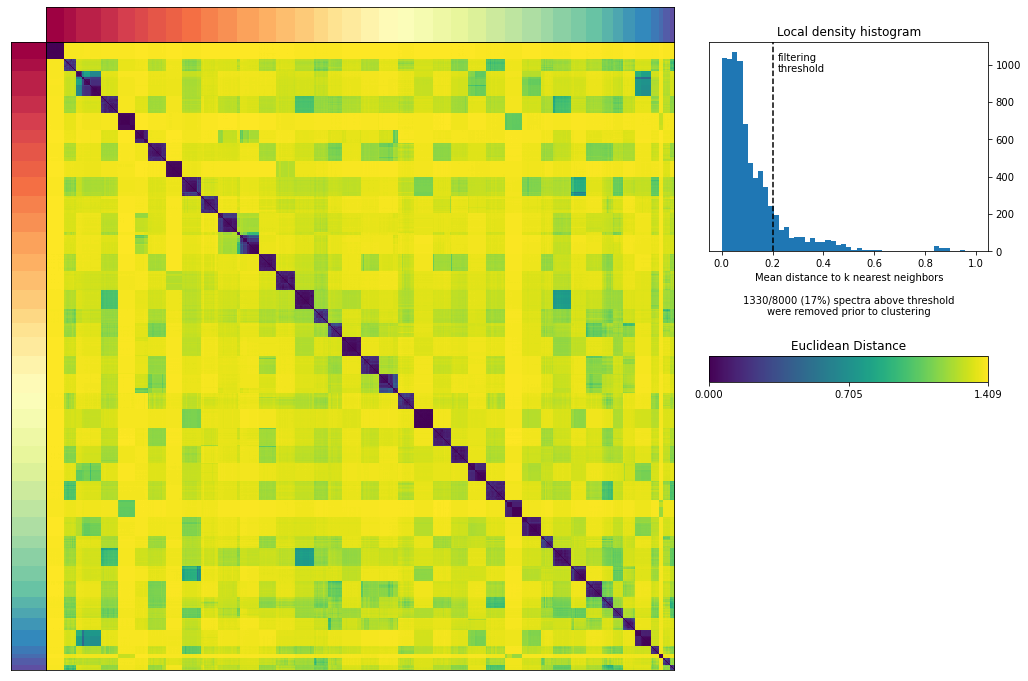

In [20]:
cnmf_obj.consensus(k=40, density_threshold=0.2)

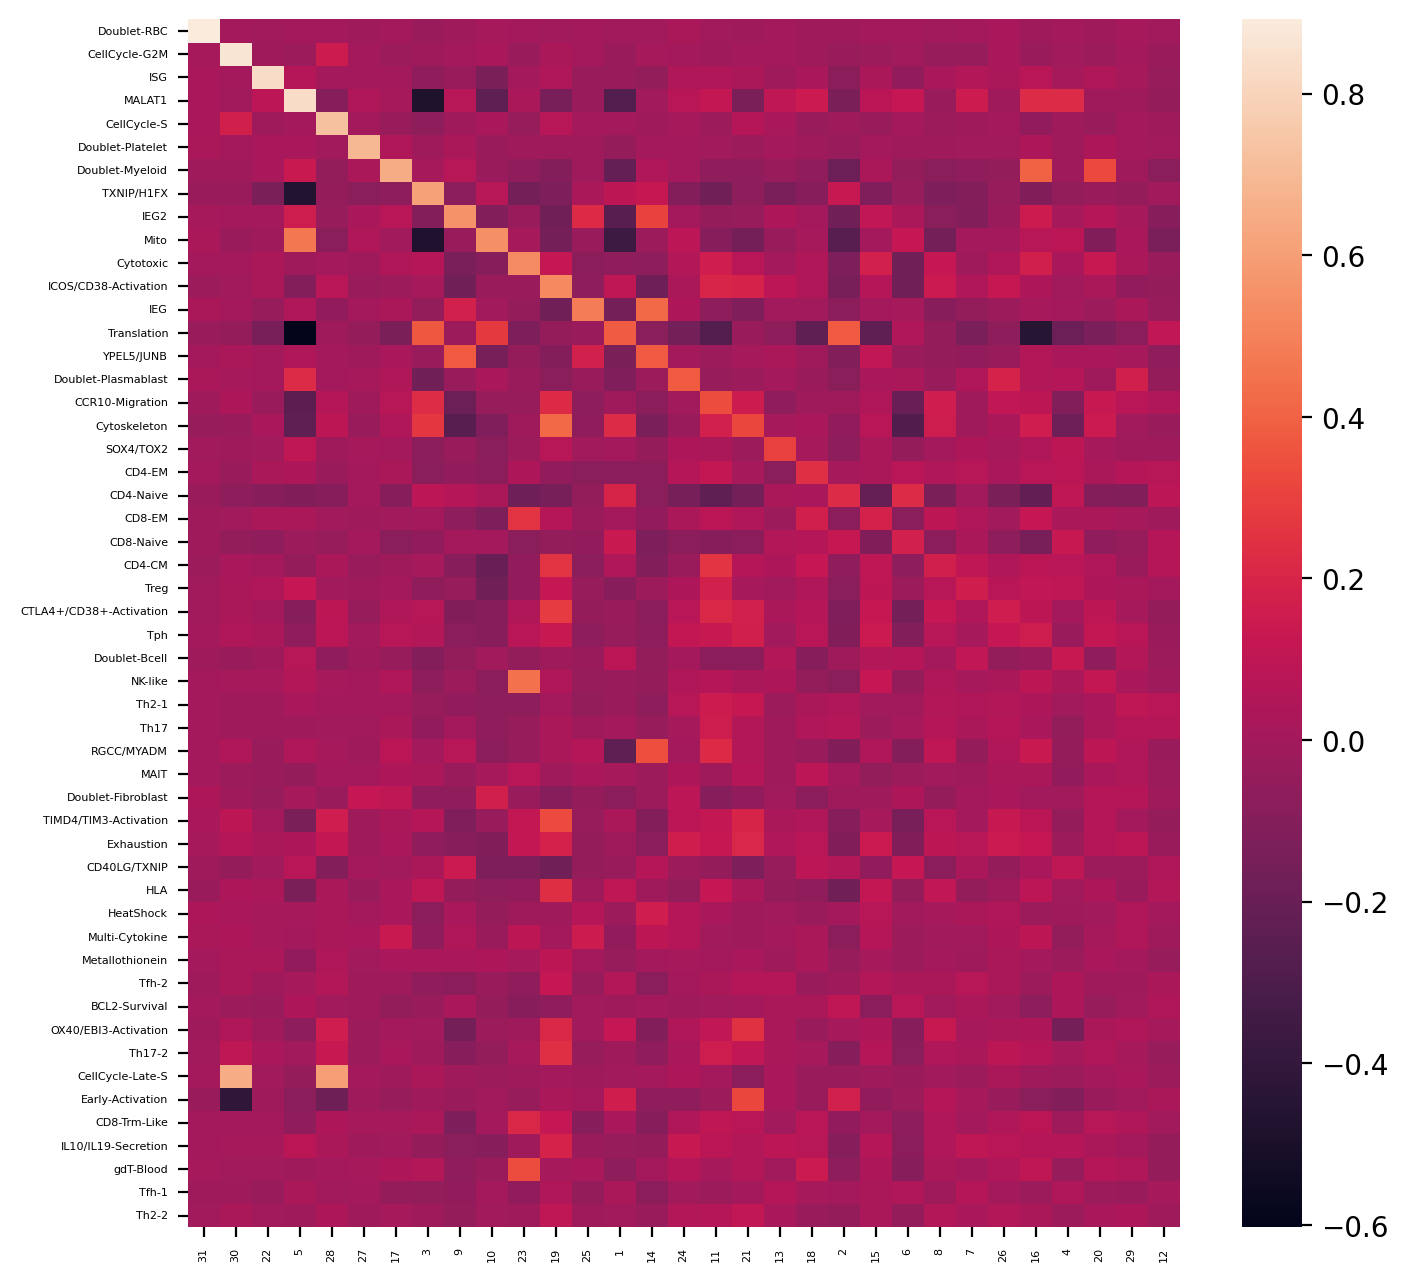

In [72]:
(usage, spectra_scores, spectra_tpm, top_genes) = cnmf_obj.load_results(K=31, density_threshold=0.2)
overlap_genes = list(set(spectra_scores.index).intersection(tcat_spectra_all.index))
mapping, unmatched, R = match_columns(tcat_spectra_all.loc[overlap_genes, :], spectra_scores.loc[overlap_genes, :])
R_for_plot = R.loc[list(mapping['X_columns']) + unmatched, mapping['Y_columns']]
rename_dict = dict(zip(mapping['Y_columns'], mapping['X_columns']))

fig,ax = plt.subplots(1,1, figsize=(8,8), dpi=200)
sns.heatmap(R_for_plot, ax=ax)
ax.set_xticks(np.arange(R_for_plot.shape[1])+0.5)
ax.set_yticks(np.arange(R_for_plot.shape[0])+0.5)
ax.set_xticklabels(R_for_plot.columns, fontsize=4)
_ = ax.set_yticklabels(R_for_plot.index, fontsize=4)